[*********************100%%**********************]  1 of 1 completed
Epoch 1/20
111/111 [==============================] - 8s 14ms/step - loss: 0.0384 - val_loss: 0.0109
Epoch 2/20
111/111 [==============================] - 1s 6ms/step - loss: 0.0104 - val_loss: 0.0109
Epoch 3/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0088
Epoch 4/20
111/111 [==============================] - 1s 6ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 5/20
111/111 [==============================] - 1s 6ms/step - loss: 0.0097 - val_loss: 0.0084
Epoch 6/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0139
Epoch 7/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0071
Epoch 8/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0084 - val_loss: 0.0086
Epoch 9/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 10/20
111/111 [=========

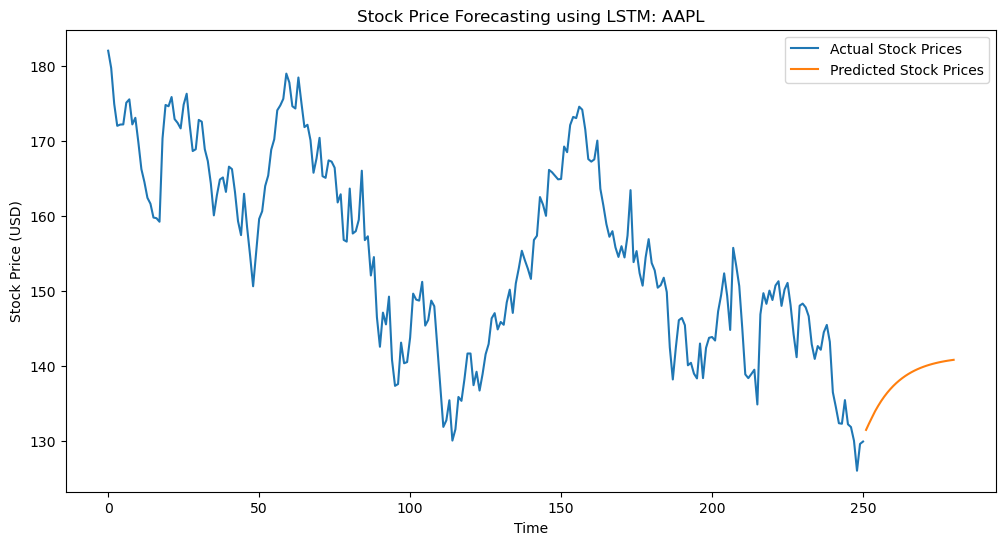

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Function to fetch historical stock price data from Yahoo Finance
def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data['Close'].values.reshape(-1, 1)

# Fetch historical stock price data for Apple Inc. (AAPL)
symbol = 'AAPL'
start_date = '2022-01-01'
end_date = '2023-01-01'
stock_prices = get_stock_data(symbol, start_date, end_date)

# Normalize the stock price data
scaler = MinMaxScaler(feature_range=(0, 1))
stock_prices_scaled = scaler.fit_transform(stock_prices)

# Create sequences for training
sequence_length = 5  # Adjust based on the desired context window
X, y = [], []
for i in range(len(stock_prices_scaled) - sequence_length):
    X.append(stock_prices_scaled[i:i+sequence_length, 0])
    y.append(stock_prices_scaled[i+sequence_length, 0])
X, y = np.array(X), np.array(y)

# Reshape the data for LSTM input: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build and train the LSTM model
model_stock_prices = Sequential()
model_stock_prices.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model_stock_prices.add(LSTM(50, return_sequences=False))
model_stock_prices.add(Dense(1))
model_stock_prices.compile(optimizer='adam', loss='mean_squared_error')

history_stock_prices = model_stock_prices.fit(X, y, epochs=20, batch_size=2, validation_split=0.1, verbose=1)

# Predict future stock prices
future_steps = 30  # Adjust based on the desired prediction horizon
predictions_scaled = []

for i in range(future_steps):
    input_sequence = stock_prices_scaled[-sequence_length:]
    input_sequence = np.reshape(input_sequence, (1, sequence_length, 1))
    predicted_value_scaled = model_stock_prices.predict(input_sequence)[0, 0]
    predictions_scaled.append(predicted_value_scaled)
    stock_prices_scaled = np.append(stock_prices_scaled, [[predicted_value_scaled]], axis=0)

# Inverse transform to get the actual predicted stock prices
predicted_stock_prices = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices')
plt.plot(np.arange(len(stock_prices), len(stock_prices)+future_steps), predicted_stock_prices, label='Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price (USD)')
plt.title(f'Stock Price Forecasting using LSTM: {symbol}')
plt.legend()
plt.show()